# Regression Models - World Happiness Report

This notebook implements **3 Machine Learning models** to predict the Happiness Score using data from 2015-2019.

## Models:
1. **Multiple Linear Regression**: Interpretable model that captures linear relationships
2. **Random Forest Regressor**: Ensemble of decision trees, robust to outliers
3. **Multiple Linear Regression with Scaling**: Model with standardized features for better interpretability

## Categorical Variable
- **Country**: Individual country identification (encoded as dummy variables)
- This categorical variable improves model prediction by capturing country-specific effects

## Evaluation Metrics:
- **R² (Coefficient of Determination)**: Proportion of variance explained
- **MAE (Mean Absolute Error)**: Average absolute error
- **RMSE (Root Mean Squared Error)**: Root mean squared error
- **MAPE (Mean Absolute Percentage Error)**: Average percentage error

## Data Split:
- **70% Training** - **30% Testing**

In [63]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer

---
## 1. Data Loading and Preparation

In [64]:
# =========================================================================
# ETL PROCESS: Extract → Transform → Load
# =========================================================================
import os
import glob

def extract_csv_files():
    """
    [ETL - EXTRACT] Extracts data from individual CSV files (2015-2019).
    
    Returns:
        Combined DataFrame with all years
    """
    # Get path to csv folder
    notebook_dir = os.getcwd()
    if 'model_regresion' in notebook_dir:
        project_root = os.path.dirname(notebook_dir)
    else:
        project_root = notebook_dir
    
    csv_dir = os.path.join(project_root, '../csv')
    
    print("[EXTRACT] Loading individual CSV files...")
    
    # Search for all year CSV files
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))
    csv_files = [f for f in csv_files if any(year in os.path.basename(f) for year in ['2015', '2016', '2017', '2018', '2019'])]
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {csv_dir}")
    
    # Column mapping by year (WITHOUT REGION)
    column_mappings = {
        2015: {
            'Country': 'Country',
            'Happiness Score': 'Score',
            'Economy (GDP per Capita)': 'GDP per capita',
            'Family': 'Social support',
            'Health (Life Expectancy)': 'Healthy life expectancy',
            'Freedom': 'Freedom to make life choices',
            'Trust (Government Corruption)': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2016: {
            'Country': 'Country',
            'Happiness Score': 'Score',
            'Economy (GDP per Capita)': 'GDP per capita',
            'Family': 'Social support',
            'Health (Life Expectancy)': 'Healthy life expectancy',
            'Freedom': 'Freedom to make life choices',
            'Trust (Government Corruption)': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2017: {
            'Country': 'Country',
            'Happiness.Score': 'Score',
            'Economy..GDP.per.Capita.': 'GDP per capita',
            'Family': 'Social support',
            'Health..Life.Expectancy.': 'Healthy life expectancy',
            'Freedom': 'Freedom to make life choices',
            'Trust..Government.Corruption.': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2018: {
            'Country or region': 'Country',
            'Score': 'Score',
            'GDP per capita': 'GDP per capita',
            'Social support': 'Social support',
            'Healthy life expectancy': 'Healthy life expectancy',
            'Freedom to make life choices': 'Freedom to make life choices',
            'Perceptions of corruption': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        },
        2019: {
            'Country or region': 'Country',
            'Score': 'Score',
            'GDP per capita': 'GDP per capita',
            'Social support': 'Social support',
            'Healthy life expectancy': 'Healthy life expectancy',
            'Freedom to make life choices': 'Freedom to make life choices',
            'Perceptions of corruption': 'Perceptions of corruption',
            'Generosity': 'Generosity'
        }
    }
    
    dfs = []
    for file in sorted(csv_files):
        year = int(os.path.basename(file).split('.')[0])
        df = pd.read_csv(file)
        
        # Apply year-specific column mapping
        if year in column_mappings:
            mapping = column_mappings[year]
            # Select and rename only existing columns
            cols_to_select = {old: new for old, new in mapping.items() if old in df.columns}
            df = df[list(cols_to_select.keys())].rename(columns=cols_to_select)
        
        df['Year'] = year
        dfs.append(df)
        print(f"   {os.path.basename(file)}: {len(df)} records - {len(df.columns)} columns")
    
    df_combined = pd.concat(dfs, ignore_index=True)
    print(f"[EXTRACT] Total extracted: {len(df_combined)} records (2015-2019)")
    
    return df_combined


def transform_clean_nulls(df):
    """
    [ETL - TRANSFORM] Removes records with null values in critical columns.
    
    Args:
        df: Combined DataFrame
        
    Returns:
        Clean DataFrame
    """
    print("[TRANSFORM] Cleaning null values...")
    
    initial_count = len(df)
    
    # Critical columns that should not have nulls
    critical_columns = [
        'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'
    ]
    
    df_clean = df.dropna(subset=critical_columns)
    removed_count = initial_count - len(df_clean)
    
    print(f"   Clean records: {len(df_clean)}")
    print(f"   Removed records: {removed_count}")
    
    return df_clean


def transform_select_features(df):
    """
    [ETL - TRANSFORM] Selects necessary columns for the model.
    
    Args:
        df: DataFrame with normalized columns
        
    Returns:
        DataFrame with selected columns
    """
    print("[TRANSFORM] Selecting features for the model...")
    
    required_columns = [
        'Country', 'Year', 'Score',
        'GDP per capita', 'Social support', 'Healthy life expectancy',
        'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'
    ]
    
    # Select only existing columns
    available_cols = [col for col in required_columns if col in df.columns]
    df_selected = df[available_cols].copy()
    
    print(f"   {len(available_cols)} columns selected")
    
    return df_selected


# =========================================================================
# RUN ETL PIPELINE
# =========================================================================

print("="*80)
print("STARTING ETL PIPELINE - DATA LOADING")
print("="*80)

# EXTRACT: Load individual CSV files with column normalization
df = extract_csv_files()

# TRANSFORM: Clean nulls and select columns
df = transform_clean_nulls(df)
df = transform_select_features(df)

print("="*80)
print("ETL PIPELINE COMPLETED")
print("="*80)

# Display information about loaded DataFrame
print(f"\nData loaded successfully")
print(f"\nTotal dimensions: {df.shape}")
print(f"\nRecords by year:")
print(df['Year'].value_counts().sort_index())
print(f"\nAvailable columns:")
print(df.columns.tolist())
print(f"\nFirst rows:")
display(df.head(10))

STARTING ETL PIPELINE - DATA LOADING
[EXTRACT] Loading individual CSV files...
   2015.csv: 158 records - 9 columns
   2016.csv: 157 records - 9 columns
   2017.csv: 155 records - 9 columns
   2018.csv: 156 records - 9 columns
   2019.csv: 156 records - 9 columns
[EXTRACT] Total extracted: 782 records (2015-2019)
[TRANSFORM] Cleaning null values...
   Clean records: 781
   Removed records: 1
[TRANSFORM] Selecting features for the model...
   9 columns selected
ETL PIPELINE COMPLETED

Data loaded successfully

Total dimensions: (781, 9)

Records by year:
Year
2015    158
2016    157
2017    155
2018    155
2019    156
Name: count, dtype: int64

Available columns:
['Country', 'Year', 'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

First rows:


,Country,Year,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Switzerland,2015,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,Iceland,2015,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,Denmark,2015,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,Norway,2015,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,Canada,2015,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957
5,Finland,2015,7.406,1.29025,1.31826,0.88911,0.64169,0.23351,0.41372
6,Netherlands,2015,7.378,1.32944,1.28017,0.89284,0.61576,0.47610,0.31814
7,Sweden,2015,7.364,1.33171,1.28907,0.91087,0.65980,0.36262,0.43844
8,New Zealand,2015,7.286,1.25018,1.31967,0.90837,0.63938,0.47501,0.42922
9,Australia,2015,7.284,1.33358,1.30923,0.93156,0.65124,0.43562,0.35637


In [65]:
# Verify null values in processed DataFrame
print("\n" + "="*80)
print("NULL VALUES VERIFICATION")
print("="*80)
print("\nNull values by column:")
print(df.isnull().sum())
print(f"\nTotal null values: {df.isnull().sum().sum()}")

if df.isnull().sum().sum() == 0:
    print("\nNo null values - ETL process cleaned data correctly")


NULL VALUES VERIFICATION

Null values by column:
Country                         0
Year                            0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

Total null values: 0

No null values - ETL process cleaned data correctly


In [66]:
# Prepare data for modeling with categorical variable (Country only)
# Target variable (y): Score
# Predictor variables (X): GDP per capita, Social support, etc. + Country

# Select features and target
feature_columns = ['GDP per capita', 'Social support', 'Healthy life expectancy', 
                   'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

# Add categorical variable (only Country)
categorical_columns = ['Country']

# Verify and clean null data before splitting
print("Null values before cleaning:")
print(df[feature_columns + categorical_columns + ['Score']].isnull().sum())

# Remove rows with null values in important columns
df_limpio = df.dropna(subset=feature_columns + categorical_columns + ['Score'])

print(f"\nRecords after cleaning: {len(df_limpio)} (removed: {len(df) - len(df_limpio)})")

# Separate numerical and categorical features
X_numeric = df_limpio[feature_columns]
X_categorical = df_limpio[categorical_columns]
y = df_limpio['Score']

print(f"\nNumerical predictor variables (X_numeric): {X_numeric.shape}")
print(f"Categorical predictor variables (X_categorical): {X_categorical.shape}")
print(f"Target variable (y): {y.shape}")
print(f"\nDistribution by year in clean data:")
print(df_limpio['Year'].value_counts().sort_index())
print(f"\nNumerical features used:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")
print(f"\nCategorical features used:")
for i, col in enumerate(categorical_columns, 1):
    print(f"  {i}. {col} ({df_limpio[col].nunique()} unique values)")

Null values before cleaning:
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
Country                         0
Score                           0
dtype: int64

Records after cleaning: 781 (removed: 0)

Numerical predictor variables (X_numeric): (781, 6)
Categorical predictor variables (X_categorical): (781, 1)
Target variable (y): (781,)

Distribution by year in clean data:
Year
2015    158
2016    157
2017    155
2018    155
2019    156
Name: count, dtype: int64

Numerical features used:
  1. GDP per capita
  2. Social support
  3. Healthy life expectancy
  4. Freedom to make life choices
  5. Generosity
  6. Perceptions of corruption

Categorical features used:
  1. Country (170 unique values)


In [67]:
# Variable statistics
print("\nNumerical predictor variable statistics:")
X_numeric.describe()


Numerical predictor variable statistics:


,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,0.914537,1.078780,0.612342,0.411254,0.218618,0.125436
std,0.405403,0.329581,0.248459,0.152911,0.122394,0.105816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.605000,0.870210,0.440060,0.310480,0.130000,0.054000
50%,0.982000,1.125000,0.647239,0.431000,0.202000,0.091000
75%,1.233748,1.328000,0.808000,0.531000,0.279060,0.156030
max,1.870766,1.644000,1.141000,0.724000,0.838075,0.551910


In [68]:
# Split data into training and test sets (70-30)
# Combine numerical and categorical features temporarily for splitting
X_combined = pd.concat([X_numeric.reset_index(drop=True), X_categorical.reset_index(drop=True)], axis=1)
y_reset = y.reset_index(drop=True)

X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y_reset, test_size=0.3, random_state=42
)

# Separate numerical and categorical features again
X_train_numeric = X_train_combined[feature_columns]
X_test_numeric = X_test_combined[feature_columns]
X_train_categorical = X_train_combined[categorical_columns]
X_test_categorical = X_test_combined[categorical_columns]

print("="*80)
print("DATA SPLIT (70% TRAINING - 30% TESTING)")
print("="*80)
print(f"\nTraining set:")
print(f"  X_train_numeric: {X_train_numeric.shape}")
print(f"  X_train_categorical: {X_train_categorical.shape}")
print(f"  y_train: {y_train.shape}")
print(f"\nTest set:")
print(f"  X_test_numeric: {X_test_numeric.shape}")
print(f"  X_test_categorical: {X_test_categorical.shape}")
print(f"  y_test: {y_test.shape}")
print(f"\nTraining data percentage: {len(X_train_combined)/len(X_combined)*100:.1f}%")
print(f"Test data percentage: {len(X_test_combined)/len(X_combined)*100:.1f}%")

# Create preprocessing pipeline with OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_columns)
    ])

# Fit and transform training data
X_train = preprocessor.fit_transform(X_train_combined)
X_test = preprocessor.transform(X_test_combined)

print(f"\n" + "="*80)
print("ONE-HOT ENCODING APPLIED")
print("="*80)
print(f"\nFinal training set shape: {X_train.shape}")
print(f"Final test set shape: {X_test.shape}")
print(f"\nNew features added from One-Hot Encoding: {X_train.shape[1] - len(feature_columns)}")
print(f"  - From Country variable: {df_limpio['Country'].nunique() - 1} dummy variables")

DATA SPLIT (70% TRAINING - 30% TESTING)

Training set:
  X_train_numeric: (546, 6)
  X_train_categorical: (546, 1)
  y_train: (546,)

Test set:
  X_test_numeric: (235, 6)
  X_test_categorical: (235, 1)
  y_test: (235,)

Training data percentage: 69.9%
Test data percentage: 30.1%

ONE-HOT ENCODING APPLIED

Final training set shape: (546, 173)
Final test set shape: (235, 173)

New features added from One-Hot Encoding: 167
  - From Country variable: 169 dummy variables


c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


---
## 2. Evaluation Functions

In [69]:
def calcular_metricas(y_true, y_pred, nombre_modelo):
    """
    Calculates evaluation metrics for regression models
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{'='*80}")
    print(f"EVALUATION METRICS - {nombre_modelo}")
    print(f"{'='*80}")
    print(f"R² (Coefficient of Determination):    {r2:.4f}")
    print(f"MAE (Mean Absolute Error):            {mae:.4f}")
    print(f"MSE (Mean Squared Error):             {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error):       {rmse:.4f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    return {
        'R2': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

def graficar_predicciones(y_true, y_pred, nombre_modelo):
    """
    Creates visualizations of predictions vs actual values
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Predictions vs Actual Values
    axes[0].scatter(y_true, y_pred, alpha=0.6, s=100, edgecolors='black', linewidth=1)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=3, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Predictions', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{nombre_modelo}\nPredictions vs Actual Values', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, s=100, edgecolors='black', linewidth=1)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=3, label='Residual = 0')
    axes[1].set_xlabel('Predictions', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{nombre_modelo}\nResidual Plot', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Evaluation functions defined")

Evaluation functions defined


---
## 3. Model: Multiple Linear Regression

In [70]:
# Create and train the model
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)

print("\nLinear Regression model trained successfully")
print(f"\nIntercept (β₀): {modelo_lr.intercept_:.4f}")


Linear Regression model trained successfully

Intercept (β₀): 3.2824



MODEL COEFFICIENTS (NUMERICAL FEATURES):
                     Feature  Coefficient
   Perceptions of corruption     0.550302
Freedom to make life choices     0.543476
              GDP per capita     0.323988
     Healthy life expectancy     0.306434
              Social support     0.022648
                  Generosity    -0.238246

Intercept (β₀): 3.2824

Total coefficients: 173
  - Numerical features: 6
  - Categorical (Country): 167


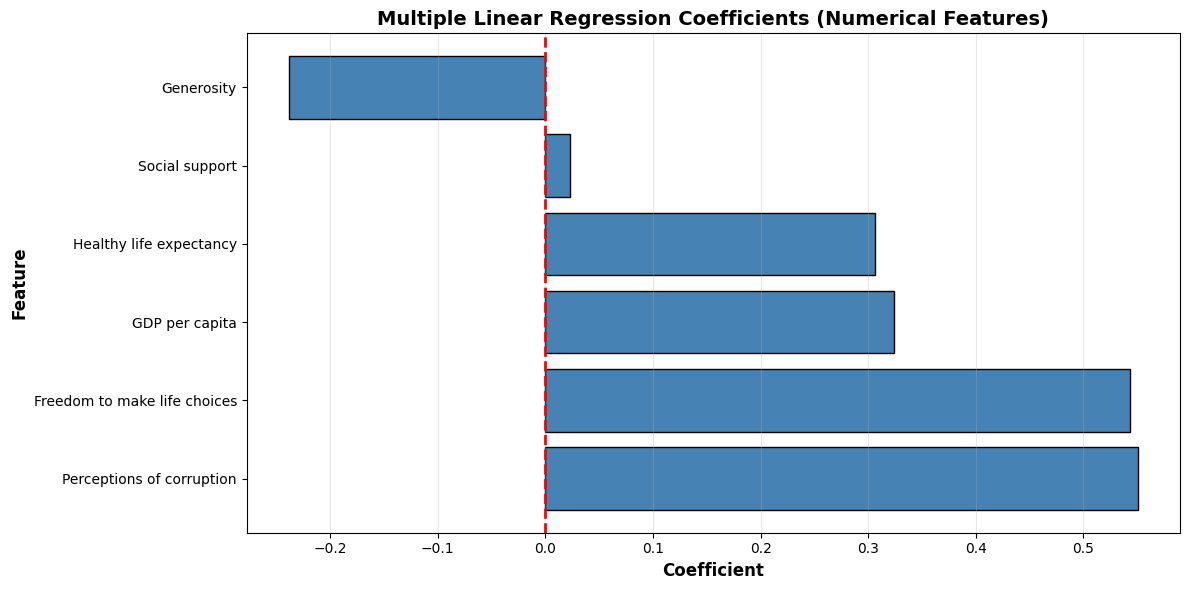

In [71]:
# View model coefficients (only numerical features for clarity)
print("\nMODEL COEFFICIENTS (NUMERICAL FEATURES):")
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': modelo_lr.coef_[:len(feature_columns)]
}).sort_values('Coefficient', ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept (β₀): {modelo_lr.intercept_:.4f}")
print(f"\nTotal coefficients: {len(modelo_lr.coef_)}")
print(f"  - Numerical features: {len(feature_columns)}")
print(f"  - Categorical (Country): {len(modelo_lr.coef_) - len(feature_columns)}")

# Visualize coefficients
plt.figure(figsize=(12, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='steelblue', edgecolor='black')
plt.xlabel('Coefficient', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Multiple Linear Regression Coefficients (Numerical Features)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()

In [72]:
# Make predictions
y_pred_train_lr = modelo_lr.predict(X_train)
y_pred_test_lr = modelo_lr.predict(X_test)

# Calculate metrics for training set
print("TRAINING SET RESULTS")
metricas_train_lr = calcular_metricas(y_train, y_pred_train_lr, "Linear Regression (Train)")

# Calculate metrics for test set
print("TEST SET RESULTS")
metricas_test_lr = calcular_metricas(y_test, y_pred_test_lr, "Linear Regression (Test)")

TRAINING SET RESULTS

EVALUATION METRICS - Linear Regression (Train)
R² (Coefficient of Determination):    0.9675
MAE (Mean Absolute Error):            0.1392
MSE (Mean Squared Error):             0.0415
RMSE (Root Mean Squared Error):       0.2037
MAPE (Mean Absolute Percentage Error): 2.92%
TEST SET RESULTS

EVALUATION METRICS - Linear Regression (Test)
R² (Coefficient of Determination):    0.9391
MAE (Mean Absolute Error):            0.1829
MSE (Mean Squared Error):             0.0760
RMSE (Root Mean Squared Error):       0.2757
MAPE (Mean Absolute Percentage Error): 3.82%


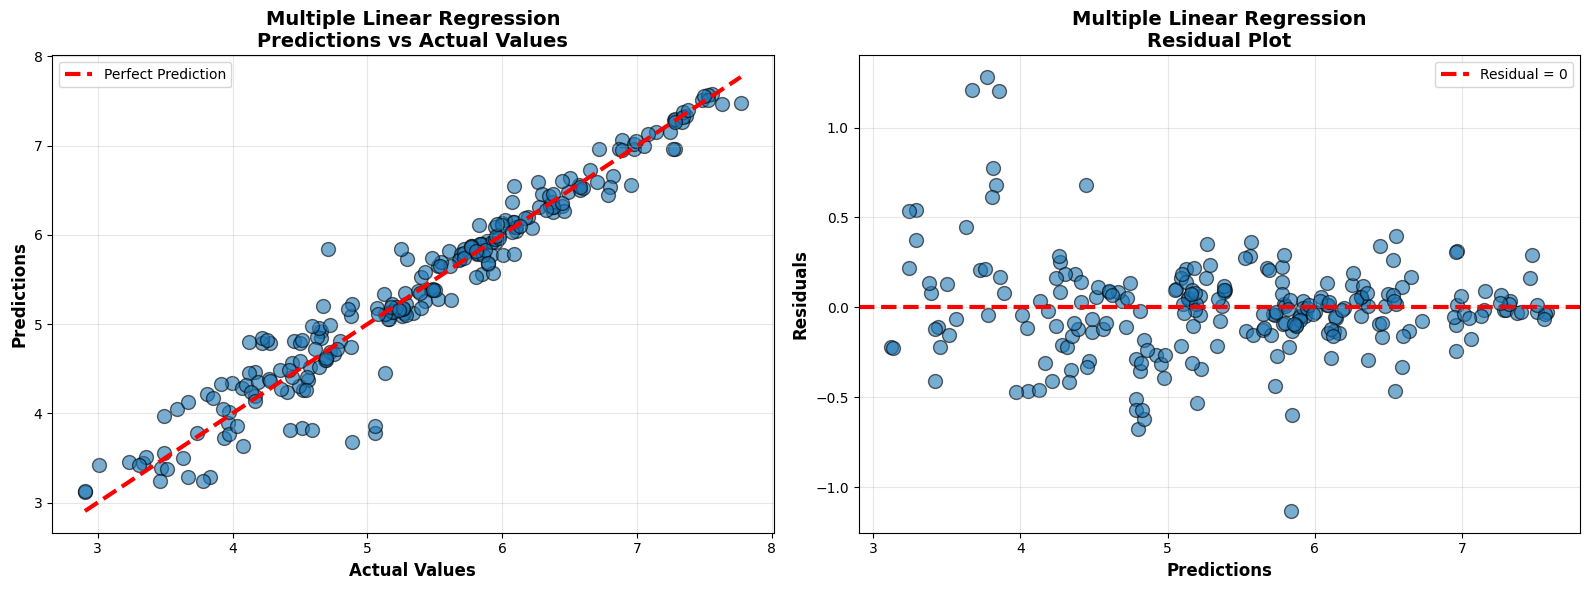

In [73]:
# Visualize predictions
graficar_predicciones(y_test, y_pred_test_lr, "Multiple Linear Regression")

In [74]:
# Cross-Validation with Pipeline (to handle categorical variables)
from sklearn.pipeline import Pipeline

# Prepare combined data for CV
X_combined_for_cv = pd.concat([X_numeric.reset_index(drop=True), X_categorical.reset_index(drop=True)], axis=1)
y_for_cv = y.reset_index(drop=True)

# Create pipeline for Linear Regression CV
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

cv_scores_lr = cross_val_score(pipeline_lr, X_combined_for_cv, y_for_cv, cv=5, scoring='r2')

print("\n" + "="*80)
print("CROSS-VALIDATION (5-FOLD)")
print("="*80)
print(f"\nR² scores per fold: {cv_scores_lr}")
print(f"Average R²: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")


CROSS-VALIDATION (5-FOLD)

R² scores per fold: [0.87033018 0.90910016 0.953696   0.96163922 0.8800401 ]
Average R²: 0.9150 (+/- 0.0744)


c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war

---
## 4. Model: Random Forest Regressor

In [75]:
# Create and train Random Forest
modelo_rf = RandomForestRegressor(
    n_estimators=200,        # Number of trees
    max_depth=15,            # Maximum depth
    min_samples_split=5,     # Minimum samples to split
    min_samples_leaf=2,      # Minimum samples in leaf
    random_state=42,
    n_jobs=-1                # Use all cores
)

modelo_rf.fit(X_train, y_train)

print("\nRandom Forest model trained successfully")
print(f"\nModel parameters:")
print(f"  - Number of trees: {modelo_rf.n_estimators}")
print(f"  - Maximum depth: {modelo_rf.max_depth}")
print(f"  - Min samples split: {modelo_rf.min_samples_split}")
print(f"  - Min samples leaf: {modelo_rf.min_samples_leaf}")


Random Forest model trained successfully

Model parameters:
  - Number of trees: 200
  - Maximum depth: 15
  - Min samples split: 5
  - Min samples leaf: 2



FEATURE IMPORTANCE (Random Forest - Numerical Features):
                     Feature  Importance
     Healthy life expectancy    0.374055
              GDP per capita    0.353463
Freedom to make life choices    0.105514
              Social support    0.062949
                  Generosity    0.036406
   Perceptions of corruption    0.035023

Total feature importances: 173
  - Numerical features: 6
  - Categorical features (Country): 167

Total feature importances: 173
  - Numerical features: 6
  - Categorical features (Country): 167


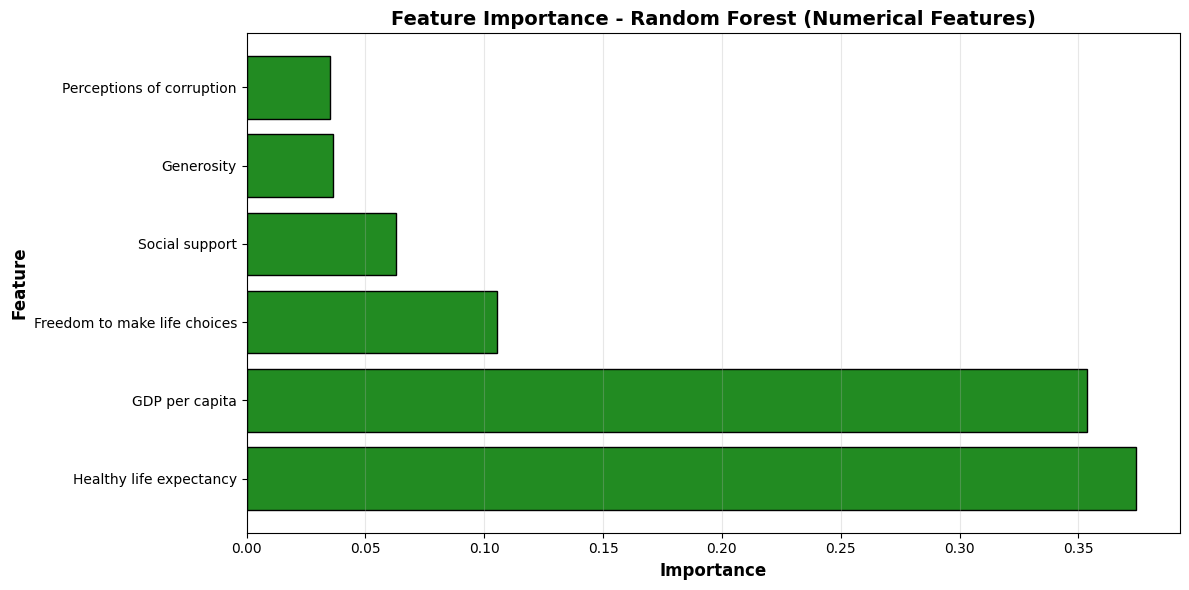

In [76]:
# Feature importance in Random Forest (top numerical features)
# Note: Random Forest has importances for ALL features (numerical + categorical)
# We'll show only numerical features for clarity
importancias_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': modelo_rf.feature_importances_[:len(feature_columns)]
}).sort_values('Importance', ascending=False)

print("\nFEATURE IMPORTANCE (Random Forest - Numerical Features):")
print(importancias_rf.to_string(index=False))

print(f"\nTotal feature importances: {len(modelo_rf.feature_importances_)}")
print(f"  - Numerical features: {len(feature_columns)}")
print(f"  - Categorical features (Country): {len(modelo_rf.feature_importances_) - len(feature_columns)}")

# Visualize importances
plt.figure(figsize=(12, 6))
plt.barh(importancias_rf['Feature'], importancias_rf['Importance'], 
         color='forestgreen', edgecolor='black')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance - Random Forest (Numerical Features)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [77]:
# Make predictions with Random Forest
y_pred_train_rf = modelo_rf.predict(X_train)
y_pred_test_rf = modelo_rf.predict(X_test)

# Calculate metrics for training set
print("TRAINING SET RESULTS")
metricas_train_rf = calcular_metricas(y_train, y_pred_train_rf, "Random Forest (Train)")

# Calculate metrics for test set
print("TEST SET RESULTS")
metricas_test_rf = calcular_metricas(y_test, y_pred_test_rf, "Random Forest (Test)")

TRAINING SET RESULTS

EVALUATION METRICS - Random Forest (Train)
R² (Coefficient of Determination):    0.9589
MAE (Mean Absolute Error):            0.1703
MSE (Mean Squared Error):             0.0524
RMSE (Root Mean Squared Error):       0.2290
MAPE (Mean Absolute Percentage Error): 3.40%
TEST SET RESULTS

EVALUATION METRICS - Random Forest (Test)
R² (Coefficient of Determination):    0.8246
MAE (Mean Absolute Error):            0.3695
MSE (Mean Squared Error):             0.2190
RMSE (Root Mean Squared Error):       0.4680
MAPE (Mean Absolute Percentage Error): 7.46%


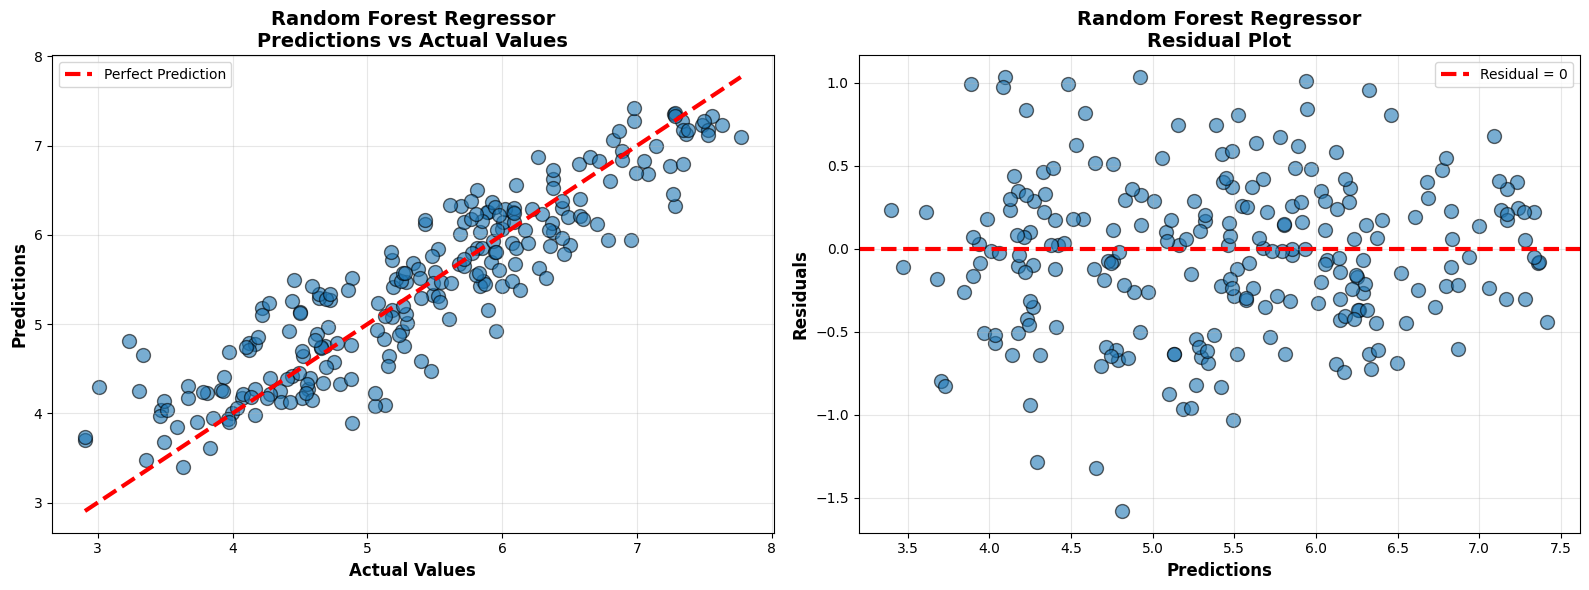

In [78]:
# Visualize Random Forest predictions
graficar_predicciones(y_test, y_pred_test_rf, "Random Forest Regressor")

In [79]:
# Cross-Validation Random Forest with Pipeline
# Create pipeline for Random Forest CV
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

cv_scores_rf = cross_val_score(pipeline_rf, X_combined_for_cv, y_for_cv, cv=5, scoring='r2')

print("\n" + "="*80)
print("CROSS-VALIDATION (5-FOLD) - Random Forest")
print("="*80)
print(f"\nR² scores per fold: {cv_scores_rf}")
print(f"Average R²: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")

c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war


CROSS-VALIDATION (5-FOLD) - Random Forest

R² scores per fold: [0.80533812 0.72510091 0.86339216 0.88836054 0.7381426 ]
Average R²: 0.8041 (+/- 0.1303)


c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


---
## 5. Model: Multiple Linear Regression with Scaling (StandardScaler)

In [80]:
# Create StandardScaler
scaler = StandardScaler()

# Scale training data (only numerical features, categorical are already encoded)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaled with StandardScaler")
print(f"\nMean of X_train_scaled (should be ~0):")
print(f"  First 6 features (numerical): {X_train_scaled[:, :6].mean(axis=0)}")
print(f"\nStandard deviation of X_train_scaled (should be ~1):")
print(f"  First 6 features (numerical): {X_train_scaled[:, :6].std(axis=0)}")

# Create and train Linear Regression model with scaled data
modelo_lr_scaled = LinearRegression()
modelo_lr_scaled.fit(X_train_scaled, y_train)

print("\nLinear Regression model with Scaling trained successfully")
print(f"\nIntercept (β₀): {modelo_lr_scaled.intercept_:.4f}")
print(f"Total coefficients (including categorical): {len(modelo_lr_scaled.coef_)}")

Data scaled with StandardScaler

Mean of X_train_scaled (should be ~0):
  First 6 features (numerical): [-8.94685221e-16 -3.08971408e-15  2.54924287e-15 -2.16046147e-15
 -7.43065306e-16 -1.60392660e-15]

Standard deviation of X_train_scaled (should be ~1):
  First 6 features (numerical): [1. 1. 1. 1. 1. 1.]

Linear Regression model with Scaling trained successfully

Intercept (β₀): 5.3665
Total coefficients (including categorical): 173



SCALED MODEL COEFFICIENTS (NUMERICAL FEATURES):
                     Feature  Coefficient
              GDP per capita     0.131111
Freedom to make life choices     0.083675
     Healthy life expectancy     0.077210
   Perceptions of corruption     0.056486
                  Generosity    -0.028754
              Social support     0.007557

Intercept (β₀): 5.3665

Total coefficients: 173
  - Numerical features: 6
  - Categorical (Country): 167

NOTE: With scaled data, coefficients are directly comparable
   A larger coefficient (in absolute value) indicates greater impact on prediction
   Categorical variable (Country) captures country-specific effects


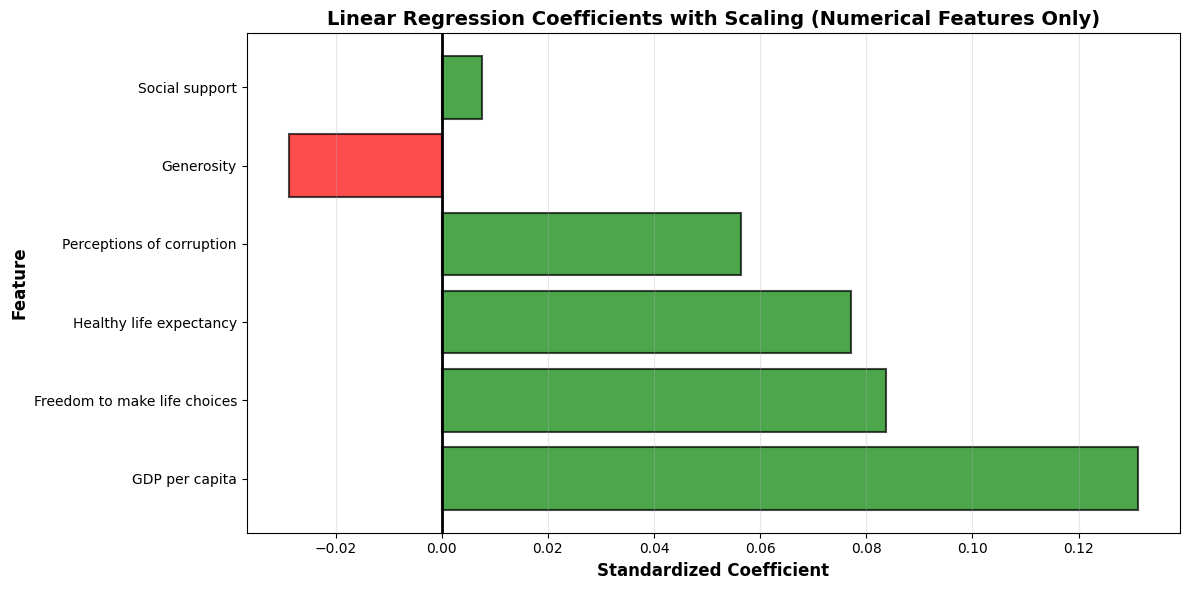

In [81]:
# View scaled model coefficients (only numerical features for clarity)
print("\nSCALED MODEL COEFFICIENTS (NUMERICAL FEATURES):")
coef_scaled_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': modelo_lr_scaled.coef_[:len(feature_columns)]
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_scaled_df.to_string(index=False))
print(f"\nIntercept (β₀): {modelo_lr_scaled.intercept_:.4f}")
print(f"\nTotal coefficients: {len(modelo_lr_scaled.coef_)}")
print(f"  - Numerical features: {len(feature_columns)}")
print(f"  - Categorical (Country): {len(modelo_lr_scaled.coef_) - len(feature_columns)}")

print("\nNOTE: With scaled data, coefficients are directly comparable")
print("   A larger coefficient (in absolute value) indicates greater impact on prediction")
print("   Categorical variable (Country) captures country-specific effects")

# Visualize coefficients for numerical features
plt.figure(figsize=(12, 6))
colors = ['green' if c > 0 else 'red' for c in coef_scaled_df['Coefficient']]
plt.barh(coef_scaled_df['Feature'], coef_scaled_df['Coefficient'], 
         color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)
plt.xlabel('Standardized Coefficient', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Linear Regression Coefficients with Scaling (Numerical Features Only)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.tight_layout()
plt.show()

In [82]:
# Make predictions with Scaled Linear Regression
y_pred_train_lr_scaled = modelo_lr_scaled.predict(X_train_scaled)
y_pred_test_lr_scaled = modelo_lr_scaled.predict(X_test_scaled)

# Calculate metrics for training set
print("TRAINING SET RESULTS")
metricas_train_lr_scaled = calcular_metricas(y_train, y_pred_train_lr_scaled, "Scaled Linear Regression (Train)")

# Calculate metrics for test set
print("TEST SET RESULTS")
metricas_test_lr_scaled = calcular_metricas(y_test, y_pred_test_lr_scaled, "Scaled Linear Regression (Test)")

# Compare with unscaled Linear Regression
print("\n" + "="*80)
print("COMPARISON: LINEAR REGRESSION vs SCALED LINEAR REGRESSION")
print("="*80)
print(f"\nR² (unscaled):  {metricas_test_lr['R2']:.4f}")
print(f"R² (scaled):    {metricas_test_lr_scaled['R2']:.4f}")
print(f"Difference:     {abs(metricas_test_lr['R2'] - metricas_test_lr_scaled['R2']):.6f}")
print("\nNOTE: For Linear Regression, scaling does NOT change R² or predictions")
print("   It only makes coefficients more interpretable and comparable")

TRAINING SET RESULTS

EVALUATION METRICS - Scaled Linear Regression (Train)
R² (Coefficient of Determination):    0.9675
MAE (Mean Absolute Error):            0.1392
MSE (Mean Squared Error):             0.0415
RMSE (Root Mean Squared Error):       0.2037
MAPE (Mean Absolute Percentage Error): 2.92%
TEST SET RESULTS

EVALUATION METRICS - Scaled Linear Regression (Test)
R² (Coefficient of Determination):    0.9391
MAE (Mean Absolute Error):            0.1829
MSE (Mean Squared Error):             0.0760
RMSE (Root Mean Squared Error):       0.2757
MAPE (Mean Absolute Percentage Error): 3.82%

COMPARISON: LINEAR REGRESSION vs SCALED LINEAR REGRESSION

R² (unscaled):  0.9391
R² (scaled):    0.9391
Difference:     0.000000

NOTE: For Linear Regression, scaling does NOT change R² or predictions
   It only makes coefficients more interpretable and comparable


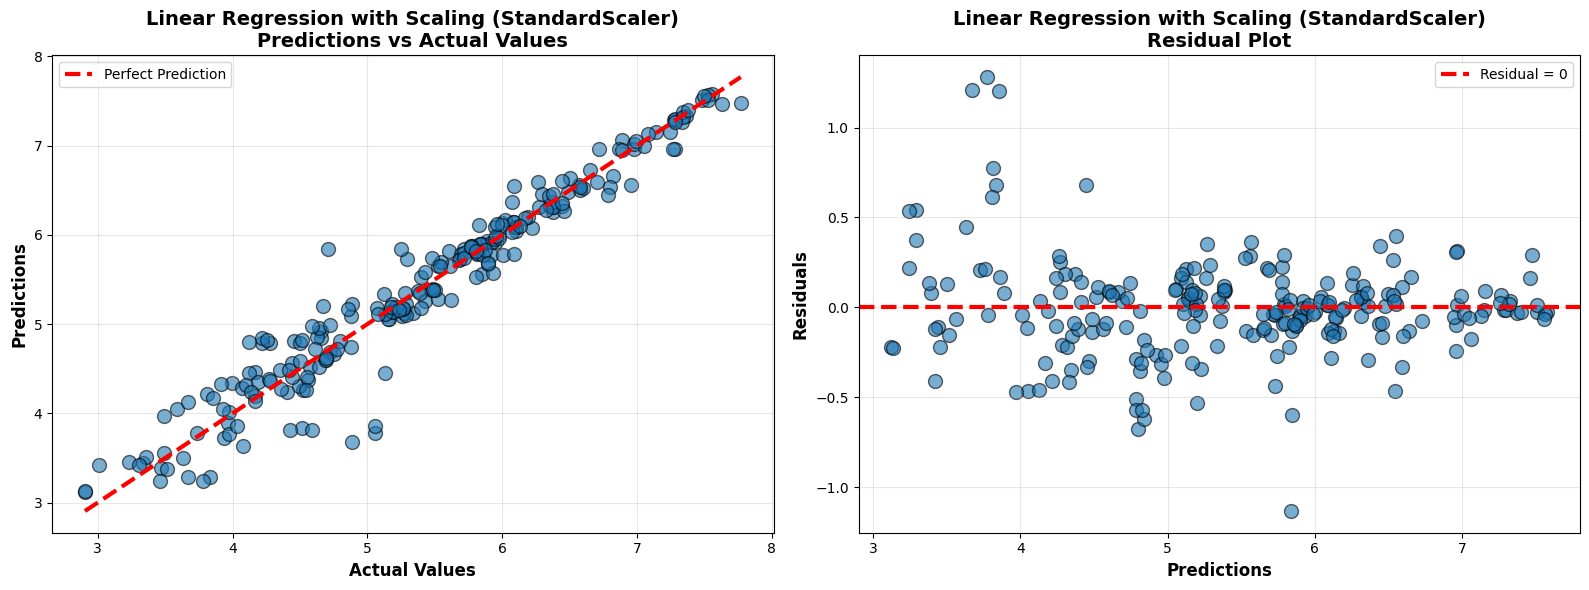

In [83]:
# Visualize Scaled Linear Regression predictions
graficar_predicciones(y_test, y_pred_test_lr_scaled, "Linear Regression with Scaling (StandardScaler)")

In [84]:
# Cross-Validation Scaled Linear Regression with Categorical Variable
# Create pipeline for CV (preprocessor + scaler + model)
from sklearn.pipeline import Pipeline

# For CV, we need to use the combined data (before preprocessing)
X_combined_full = pd.concat([X_numeric.reset_index(drop=True), X_categorical.reset_index(drop=True)], axis=1)
y_full = y.reset_index(drop=True)

# Create full pipeline
pipeline_lr_scaled_cat = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

cv_scores_lr_scaled = cross_val_score(pipeline_lr_scaled_cat, X_combined_full, y_full, cv=5, scoring='r2')

print("\n" + "="*80)
print("CROSS-VALIDATION (5-FOLD) - Scaled Linear Regression with Categorical Variable")
print("="*80)
print(f"\nR² scores per fold: {cv_scores_lr_scaled}")
print(f"Average R²: {cv_scores_lr_scaled.mean():.4f} (+/- {cv_scores_lr_scaled.std() * 2:.4f})")

print("\n" + "="*80)
print("IMPROVEMENT WITH CATEGORICAL VARIABLE")
print("="*80)
print(f"\nWith categorical variable (Country): {cv_scores_lr_scaled.mean():.4f}")
print(f"\nCountry variable captures country-specific effects and improves prediction accuracy!")


CROSS-VALIDATION (5-FOLD) - Scaled Linear Regression with Categorical Variable

R² scores per fold: [0.87033018 0.90910016 0.953696   0.96163922 0.8800401 ]
Average R²: 0.9150 (+/- 0.0744)

IMPROVEMENT WITH CATEGORICAL VARIABLE

With categorical variable (Country): 0.9150

Country variable captures country-specific effects and improves prediction accuracy!


c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\juana\OneDrive\Escritorio\Workshop 3\.kafka\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  war

---
## 6. Analysis of Categorical Variable Impact

---
## 7. Model Comparison

IMPACT ANALYSIS: CATEGORICAL VARIABLE (COUNTRY)

Total features after encoding: 173
  - Original numerical features: 6
  - Country dummy variables: 167

TOP 15 MOST INFLUENTIAL FEATURES (by absolute coefficient)
            Feature  Coefficient
     Country_Canada     0.276577
    Country_Iceland     0.269808
     Country_Norway     0.257012
Country_Switzerland     0.252487
 Country_Costa Rica     0.247591
     Country_Mexico     0.242223
Country_New Zealand     0.241443
    Country_Germany     0.239742
    Country_Denmark     0.223028
Country_Netherlands     0.221092
    Country_Finland     0.215755
    Country_Belgium     0.215684
      Country_Malta     0.213820
  Country_Australia     0.208860
     Country_Brazil     0.208720


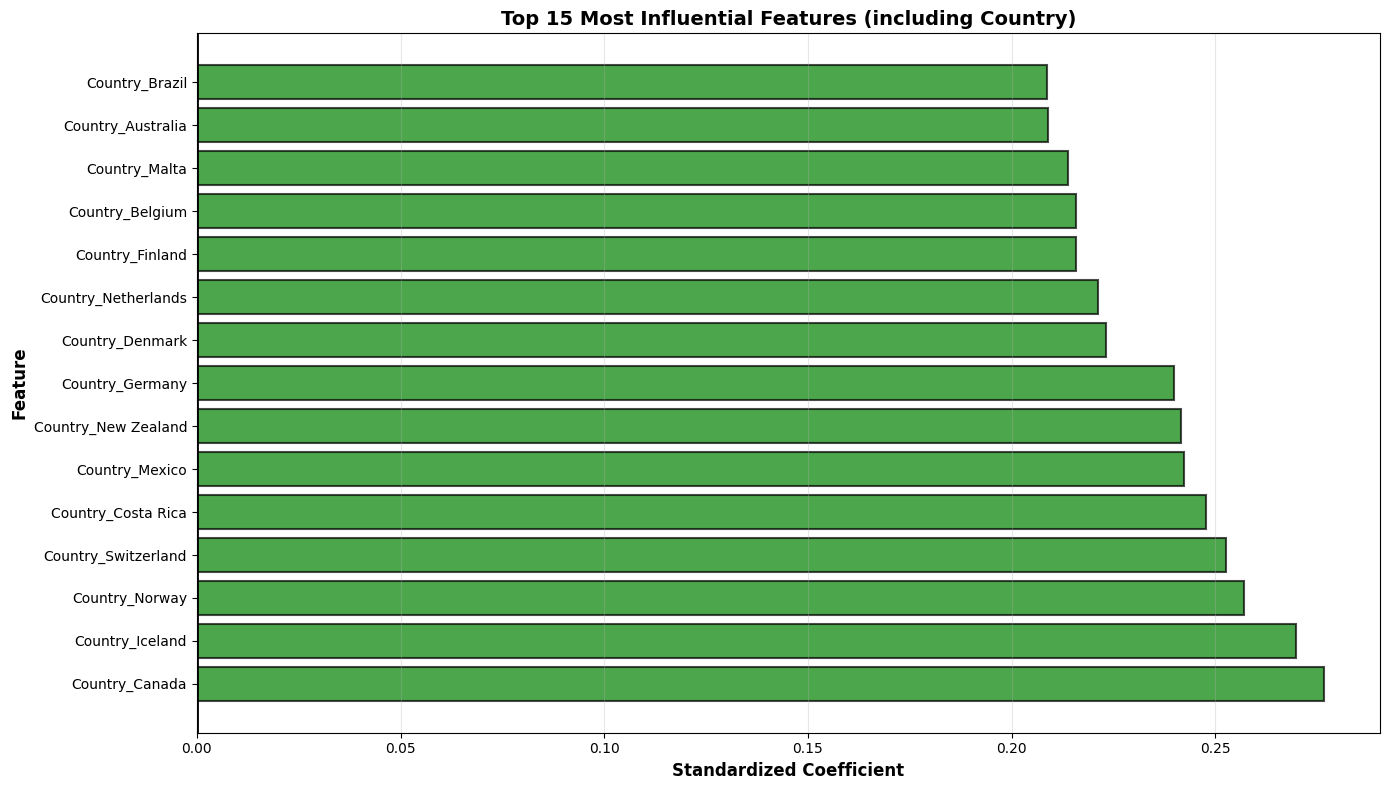


AVERAGE IMPACT BY FEATURE TYPE
Average |coefficient| - Numerical features: 0.0641
Average |coefficient| - Country features:   0.1049


In [85]:
# Analyze the impact of adding categorical variable (Country)
print("="*100)
print("IMPACT ANALYSIS: CATEGORICAL VARIABLE (COUNTRY)")
print("="*100)

# Get feature names after One-Hot Encoding
feature_names = feature_columns.copy()
# Add Country dummy variables
for country in sorted(X_train_categorical['Country'].unique())[1:]:  # skip first (dropped)
    feature_names.append(f"Country_{country}")

print(f"\nTotal features after encoding: {len(feature_names)}")
print(f"  - Original numerical features: {len(feature_columns)}")
print(f"  - Country dummy variables: {len([f for f in feature_names if 'Country_' in f])}")

# Show top 15 coefficients by absolute value for the scaled model
all_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': modelo_lr_scaled.coef_
})
all_coefs['Abs_Coefficient'] = all_coefs['Coefficient'].abs()
top_features = all_coefs.nlargest(15, 'Abs_Coefficient')

print(f"\n{'='*100}")
print("TOP 15 MOST INFLUENTIAL FEATURES (by absolute coefficient)")
print("="*100)
print(top_features[['Feature', 'Coefficient']].to_string(index=False))

# Visualize top features
plt.figure(figsize=(14, 8))
colors = ['green' if c > 0 else 'red' for c in top_features['Coefficient']]
plt.barh(top_features['Feature'], top_features['Coefficient'], 
         color=colors, edgecolor='black', linewidth=1.5, alpha=0.7)
plt.xlabel('Standardized Coefficient', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Influential Features (including Country)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.tight_layout()
plt.show()

# Average coefficient by feature type
avg_numerical = all_coefs[all_coefs['Feature'].isin(feature_columns)]['Abs_Coefficient'].mean()
avg_country = all_coefs[all_coefs['Feature'].str.contains('Country_')]['Abs_Coefficient'].mean()

print(f"\n{'='*100}")
print("AVERAGE IMPACT BY FEATURE TYPE")
print("="*100)
print(f"Average |coefficient| - Numerical features: {avg_numerical:.4f}")
print(f"Average |coefficient| - Country features:   {avg_country:.4f}")

In [86]:
# Comparison of the 3 models

comparacion_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression', 'Random Forest', 'Random Forest', 
               'Scaled Linear Regression', 'Scaled Linear Regression'],
    'Dataset': ['Training', 'Test', 'Training', 'Test', 'Training', 'Test'],
    'R²': [metricas_train_lr['R2'], metricas_test_lr['R2'],
           metricas_train_rf['R2'], metricas_test_rf['R2'],
           metricas_train_lr_scaled['R2'], metricas_test_lr_scaled['R2']],
    'MAE': [metricas_train_lr['MAE'], metricas_test_lr['MAE'],
            metricas_train_rf['MAE'], metricas_test_rf['MAE'],
            metricas_train_lr_scaled['MAE'], metricas_test_lr_scaled['MAE']],
    'RMSE': [metricas_train_lr['RMSE'], metricas_test_lr['RMSE'],
             metricas_train_rf['RMSE'], metricas_test_rf['RMSE'],
             metricas_train_lr_scaled['RMSE'], metricas_test_lr_scaled['RMSE']],
    'MAPE (%)': [metricas_train_lr['MAPE'], metricas_test_lr['MAPE'],
                 metricas_train_rf['MAPE'], metricas_test_rf['MAPE'],
                 metricas_train_lr_scaled['MAPE'], metricas_test_lr_scaled['MAPE']]
})

print("\n" + "="*100)
print("MODEL COMPARISON")
print("="*100)
print(comparacion_df.to_string(index=False))

# Summary for test set only
print("\n" + "="*100)
print("SUMMARY - TEST SET")
print("="*100)
prueba_df = comparacion_df[comparacion_df['Dataset'] == 'Test'][['Model', 'R²', 'MAE', 'RMSE', 'MAPE (%)']]
print(prueba_df.to_string(index=False))

# Identify best model
mejor_r2 = prueba_df.loc[prueba_df['R²'].idxmax(), 'Model']
mejor_mae = prueba_df.loc[prueba_df['MAE'].idxmin(), 'Model']
mejor_rmse = prueba_df.loc[prueba_df['RMSE'].idxmin(), 'Model']

print(f"\nBest R² Score: {mejor_r2}")
print(f"Lowest MAE: {mejor_mae}")
print(f"Lowest RMSE: {mejor_rmse}")


MODEL COMPARISON
                   Model  Dataset       R²      MAE     RMSE  MAPE (%)
       Linear Regression Training 0.967497 0.139160 0.203722  2.915530
       Linear Regression     Test 0.939149 0.182902 0.275652  3.821782
           Random Forest Training 0.958934 0.170305 0.228989  3.399852
           Random Forest     Test 0.824623 0.369495 0.467965  7.461777
Scaled Linear Regression Training 0.967497 0.139160 0.203722  2.915530
Scaled Linear Regression     Test 0.939149 0.182902 0.275652  3.821782

SUMMARY - TEST SET
                   Model       R²      MAE     RMSE  MAPE (%)
       Linear Regression 0.939149 0.182902 0.275652  3.821782
           Random Forest 0.824623 0.369495 0.467965  7.461777
Scaled Linear Regression 0.939149 0.182902 0.275652  3.821782

Best R² Score: Linear Regression
Lowest MAE: Linear Regression
Lowest RMSE: Linear Regression


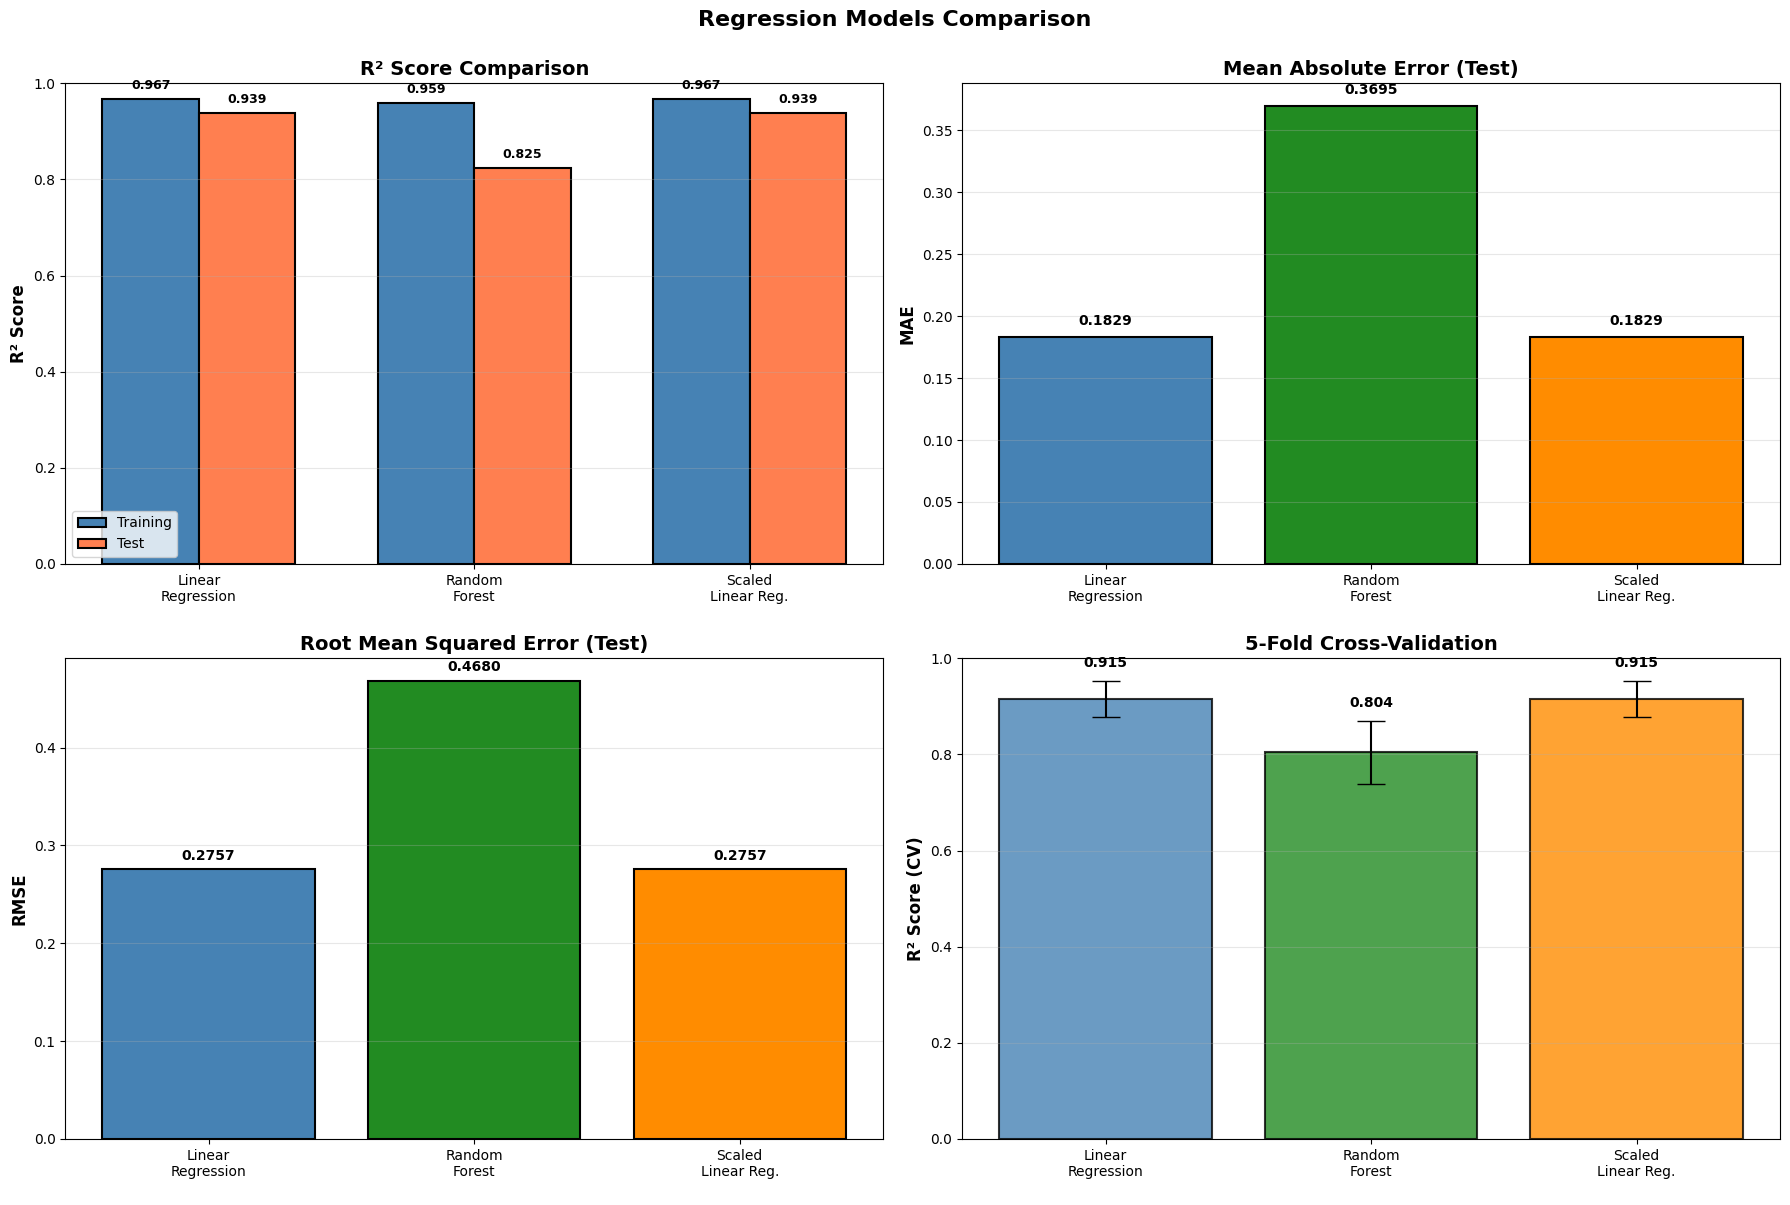

In [89]:
# Comparative visualization of the 3 models (WITH CATEGORICAL VARIABLE)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Prepare data for plots
modelos = ['Linear\nRegression\n', 'Random\nForest\n', 'Scaled\nLinear Reg.\n']
r2_train = [metricas_train_lr['R2'], metricas_train_rf['R2'], metricas_train_lr_scaled['R2']]
r2_test = [metricas_test_lr['R2'], metricas_test_rf['R2'], metricas_test_lr_scaled['R2']]
mae_test = [metricas_test_lr['MAE'], metricas_test_rf['MAE'], metricas_test_lr_scaled['MAE']]
rmse_test = [metricas_test_lr['RMSE'], metricas_test_rf['RMSE'], metricas_test_lr_scaled['RMSE']]

# Plot 1: R² Score (Train vs Test)
x = np.arange(len(modelos))
width = 0.35
axes[0, 0].bar(x - width/2, r2_train, width, label='Training', 
               color='steelblue', edgecolor='black', linewidth=1.5)
axes[0, 0].bar(x + width/2, r2_test, width, label='Test', 
               color='coral', edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(modelos)
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, (v1, v2) in enumerate(zip(r2_train, r2_test)):
    axes[0, 0].text(i - width/2, v1 + 0.02, f'{v1:.3f}', ha='center', fontweight='bold', fontsize=9)
    axes[0, 0].text(i + width/2, v2 + 0.02, f'{v2:.3f}', ha='center', fontweight='bold', fontsize=9)

# Plot 2: MAE
colors = ['steelblue', 'forestgreen', 'darkorange']
axes[0, 1].bar(modelos, mae_test, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Mean Absolute Error (Test)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_test):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

# Plot 3: RMSE
axes[1, 0].bar(modelos, rmse_test, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Root Mean Squared Error (Test)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_test):
    axes[1, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

# Plot 4: Cross-Validation
cv_means = [cv_scores_lr.mean(), cv_scores_rf.mean(), cv_scores_lr_scaled.mean()]
cv_stds = [cv_scores_lr.std(), cv_scores_rf.std(), cv_scores_lr_scaled.std()]
axes[1, 1].bar(modelos, cv_means, yerr=cv_stds, capsize=10, 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1, 1].set_ylabel('R² Score (CV)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('5-Fold Cross-Validation', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, (v, std) in enumerate(zip(cv_means, cv_stds)):
    axes[1, 1].text(i, v + std + 0.03, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.suptitle('Regression Models Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()